<a href="https://colab.research.google.com/github/menglin874/BITM/blob/main/Log_Gabor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
import math
import cv2,os


In [ ]:
pip install LogGabor

Input image

In [ ]:
from LogGabor import imread
image = imread('/content/drive/MyDrive/outputs/covidlung.jpg')

shrink = (slice(0, None, 1), slice(0, None, 1))
covid = img_as_float(image)[shrink] #(624, 628)
print(covid.shape)
cov = covid.reshape(128,128)

plt.imshow(covid, cmap = 'gray')
plt.title("covid image orginale")
plt.show()

Log-Gabor filter

In [ ]:
number_scales = 4          # scale resolution
number_orientations = 6    # orientation resolution
N = 128                 # image dimensions
def getFilter(f_0, theta_0):
    # filter configuration
    scale_bandwidth =  0.996 * math.sqrt(2/3)
    angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/number_orientations)

    # x,y grid
    extent = np.arange(-N/2, N/2 + N%2)
    x, y = np.meshgrid(extent,extent)

    mid = int(N/2)
    ## orientation component ##
    theta = np.arctan2(y,x)
    center_angle = ((np.pi/number_orientations) * theta_0) if (f_0 % 2) \
                else ((np.pi/number_orientations) * (theta_0+0.5))

    # calculate (theta-center_theta), we calculate cos(theta-center_theta) 
    # and sin(theta-center_theta) then use atan to get the required value,
    # this way we can eliminate the angular distance wrap around problem
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    ds = sintheta * math.cos(center_angle) - costheta * math.sin(center_angle)    
    dc = costheta * math.cos(center_angle) + sintheta * math.sin(center_angle)  
    dtheta = np.arctan2(ds,dc)

    orientation_component =  np.exp(-0.5 * (dtheta/angle_bandwidth)**2)

    ## frequency componenet ##
    # go to polar space
    raw = np.sqrt(x**2+y**2)
    # set origin to 1 as in the log space zero is not defined
    raw[mid,mid] = 1
    # go to log space
    raw = np.log2(raw)

    center_scale = math.log2(N) - f_0
    draw = raw-center_scale
    frequency_component = np.exp(-0.5 * (draw/ scale_bandwidth)**2)

    # reset origin to zero (not needed as it is already 0?)
    frequency_component[mid,mid] = 0

    return frequency_component * orientation_component

In [ ]:
def getLogGaborKernal(scale, angle, logfun=math.log2, norm = True):
    # setup up filter configuration
    center_scale = logfun(N) - scale          
    center_angle = ((np.pi/number_orientations) * angle) if (scale % 2) \
                else ((np.pi/number_orientations) * (angle+0.5))
    scale_bandwidth =  0.996 * math.sqrt(2/3)
    angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/number_orientations)

    # 2d array that will hold the filter
    kernel = np.zeros((N, N))
    # get the center of the 2d array so we can shift origin
    middle = math.ceil((N/2)+0.1)-1

    # calculate the filter
    for x in range(0,constantDim):
        for y in range(0,constantDim):
            # get the transformed x and y where origin is at center
            # and positive x-axis goes right while positive y-axis goes up
            x_t, y_t = (x-middle),-(y-middle)
            # calculate the filter value at given index
            kernel[y,x] = logGaborValue(x_t,y_t,center_scale,center_angle,
        scale_bandwidth, angle_bandwidth,logfun)

    # normalize the filter energy
    if norm:
        Kernel = kernel / np.sum(kernel**2)
    return kernel

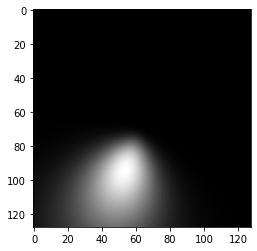

In [ ]:
logfilter1 = getFilter(2, np.pi)

plt.imshow(logfilter1,cmap = 'gray')

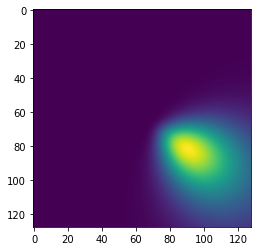

In [ ]:
logfilter2 = getFilter(2, np.pi/5)

plt.imshow(logfilter2)

In [ ]:
kernels = filters
def compute_feats(image, kernels):#Calculating the characteristic function
  feats = np.zeros((len(kernels), 2), dtype=np.double)
  for k, kernel in enumerate(kernels):
    filtered = ndi.convolve(image, kernel, mode='wrap')
    feats[k, 0] = filtered.mean()
    feats[k, 1] = filtered.var()
  return feats
#PreparationReferenceFeatures
ref_feats = np.zeros((1, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(covid, kernels)
#ref_feats[1, :, :] = compute_feats(grass, kernels)
#ref_feats[2, :, :] = compute_feats(gravel, kernels)

In [ ]:
def match(feats, ref_feats):# Matching function for calculating least square error
  min_error = np.inf
  min_i = None
  for i in range(ref_feats.shape[0]):
    error = np.sum((feats - ref_feats[i, :])**2)
    if error < min_error:
      min_error = error
      min_i = i
  return min_i

In [ ]:
# Calculate the power diagram of the corresponding kernel after normalisation
def power(image, kernel):
# Normalisation of images for better comparison
  image = (image - image.mean()) / image.std()
  return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 + ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

In [ ]:
##Drawing filters and diagrams

results = []
kernel_params = []
filters = []
'''
for theta in (0, 1):
  theta = theta / 4. * np.pi
  for frequency in (0.1, 0.4):
    kernel = gabor_kernel(frequency, theta=theta)
    '''
ksize = [7,9,11,13] 
lamda = np.pi/2.0         
for K in range(4):

  #print(theta)
  for theta in np.arange(0, np.pi+0.1, np.pi / 5): # orientation，0°，36°，72°，108°，144°，180°
    kern = getFilter(ksize[K], theta)
    kern /= 1.5*kern.sum()
    
    params = 'theta=%d,\néchelle=%.2f' % (theta * 180 / np.pi, ksize[K])#核的标题
    kernel_params.append(params)
  
# Save the kernel and power images for each image
    filters.append(kern)
    results.append(power(covid, kern))
    #results.append((kern, power(covid, kern)))

kernels = filters
def compute_feats(image, kernels):#Calculating the characteristic function
  feats = np.zeros((len(kernels), 2), dtype=np.double)
  for k, kernel in enumerate(kernels):
    filtered = ndi.convolve(image, kernel, mode='wrap')
    feats[k, 0] = filtered.mean()
    feats[k, 1] = filtered.var()
  return feats
#PreparationReferenceFeatures
ref_feats = np.zeros((1, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(covid, kernels)
#ref_feats[1, :, :] = compute_feats(grass, kernels)
#ref_feats[2, :, :] = compute_feats(gravel, kernels)

#print('Rotated images matched against references using Gabor filter banks:')

#print('original: covid, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(covid, angle=30, reshape=False), kernels)
#print(image_names[match(feats, ref_feats)])

In [ ]:
print(len(results)) #24
print(len(kernel_params))
for temp in range(len(results)):
  plt.subplot(6, 4, temp + 1)
  plt.imshow(results[temp])
plt.show()

In [ ]:

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 16))
plt.gray()
fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

#axes[0][0].axis('off')

col_names= (7, 9, 11, 13) # j
row_names= ( 0, 36, 72, 108, 144, 180) # i 

for i in range(4):
  for j in range(6):
    vmin = np.min(results)
    vmax = np.max(results)
    params = 'theta=%d,\néchelle=%.2f' % (row_names[j],col_names[i])#核的标题
    #kernel_params.append(params)
    
    axes[i][j].imshow(results[i*j],cmap = 'gray') #vmin=vmin, vmax=vmax 
    axes[i][j].set_title(params, fontsize=9)
    #axes[i][j].axis('off')

In [ ]:
print(type(results))
print(len(results))

print(results[0][0,0])
print(results[1][0,0])

for i in range(1,24):
  print(results[i][0,0])
  if results[i-1][0,0]<results[i][0,0]:
    vn = i-1
#print(vn)

vals = list()

for i in range(624):
  for j in range(628):
    for k in range(1,24):
      if results[k-1][i,j]<=results[k][i,j]:
        val = k-1
    #print(val)
    vals.append(val)
print(len(vals))



In [ ]:
vqls = np.array(vals)
print(vqls.shape)
vqls.reshape((624,628))
vq = vqls.reshape((624,628))
print(vq.shape)

In [ ]:
## Codage binares du grays
 
# This function generates all n bit Gray
# codes and prints the generated codes
def generateGrayarr(n):
 
    # base case
    if (n <= 0):
        return
 
    # 'arr' will store all generated codes
    arr = list()
 
    # start with one-bit pattern
    arr.append("0")
    arr.append("1")
 
    # Every iteration of this loop generates
    # 2*i codes from previously generated i codes.
    i = 2
    j = 0
    while(True):
 
        if i >= 1 << n:
            break
     
        # Enter the previously generated codes
        # again in arr[] in reverse order.
        # Nor arr[] has double number of codes.
        for j in range(i - 1, -1, -1):
            arr.append(arr[j])
 
        # append 0 to the first half
        for j in range(i):
            arr[j] = "0" + arr[j]
 
        # append 1 to the second half
        for j in range(i, 2 * i):
            arr[j] = "1" + arr[j]
        i = i << 1
 
    # print contents of arr[]
    for i in range(len(arr)):
        print(arr[i])
    return arr
 
# Driver Code
generateGrayarr(5)
 
# This code is contributed
# by Mohit kumar 29


In [ ]:
code = generateGrayarr(5)[0:24]
print(type(code))

cdg = np.array(code)
#print(cdg)

img = np.zeros((624,628))

for i in range(624):
  for j in range(628):
    n = vq[i,j]
    bi = code[n]
    
    img[i,j] = int(bi,2)/255
    #print(img[i,j]) 



#print(img)
plt.imshow(img, cmap = 'gray')
plt.show()
